In [1]:
from bayes_opt import BayesianOptimization
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

# Target Function

Lets create a target 1-D function with multiple local maxima to test and visualize how the [BayesianOptimization](https://github.com/fmfn/BayesianOptimization) package works. The target function we will try to maximize is the following:

$$f(x) = e^{-(x - 2)^2} + e^{-\frac{(x - 6)^2}{10}} + \frac{1}{x^2 + 1}, $$ its maximum is at $x = 2$ and we will restrict the interval of interest to $x \in (-2, 10)$.

In [2]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

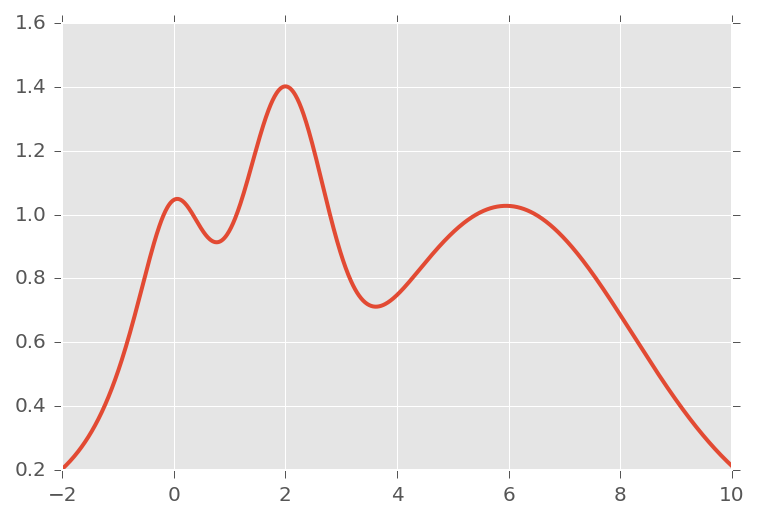

In [3]:
x = np.linspace(-2, 10, 1000)
y = target(x)

plt.plot(x, y)

# Create a BayesianOptimization Object

Enter the target function to be maximized, its variable(s) and their corresponding ranges (see this [example](https://github.com/fmfn/BayesianOptimization/blob/master/examples/usage.py) for a multi-variable case). A minimum number of 2 initial guesses is necessary to kick start the algorithms, these can either be random or user defined.

In this example we will use the Upper Confidence Bound (UCB) as our utility function. It has the free parameter
$\kappa$ which control the balance between exploration and exploitation; we will set $\kappa=5$ which, in this case, makes the algorithm quite bold. Additionally we will use the cubic correlation in our Gaussian Process.

# Plotting and visualizing the algorithm at each step

### Lets first define a couple functions to make plotting easier

In [4]:
def posterior(bo, xmin=-2, xmax=10):
    xmin, xmax = -2, 10
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma2 = bo.gp.predict(np.linspace(xmin, xmax, 1000).reshape(-1, 1), eval_MSE=True)
    return mu, np.sqrt(sigma2)

def plot_gp(bo, x, y):
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(bo)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(bo.X.flatten(), bo.Y, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility = bo.util.utility(x.reshape((-1, 1)), bo.gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

Correlation lenght ~ $1 / \theta$

In [80]:
bo = BayesianOptimization(target, {'x': (-2, 10)})
gp_params = {'corr': 'cubic', 'theta0': 1e0, 'thetaL': 1e-1, 'thetaU': 1e1}
max_params = {'acq': 'ei', 'xi': 0.1}

### Two random points

After we probe two points at random, we can fit a Gaussian Process and start the bayesian optimization procedure. Two points should give us a uneventful posterior with the uncertainty growing as we go further from the observations.

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |    1.03310 |    0.2113 | 
    2 | 00m00s |    1.04633 |    0.0069 | 
    3 | 00m00s |    0.75096 |    3.3002 | 
    4 | 00m00s |    1.39566 |    2.0857 | 
    5 | 00m00s |    1.02524 |    0.2473 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 


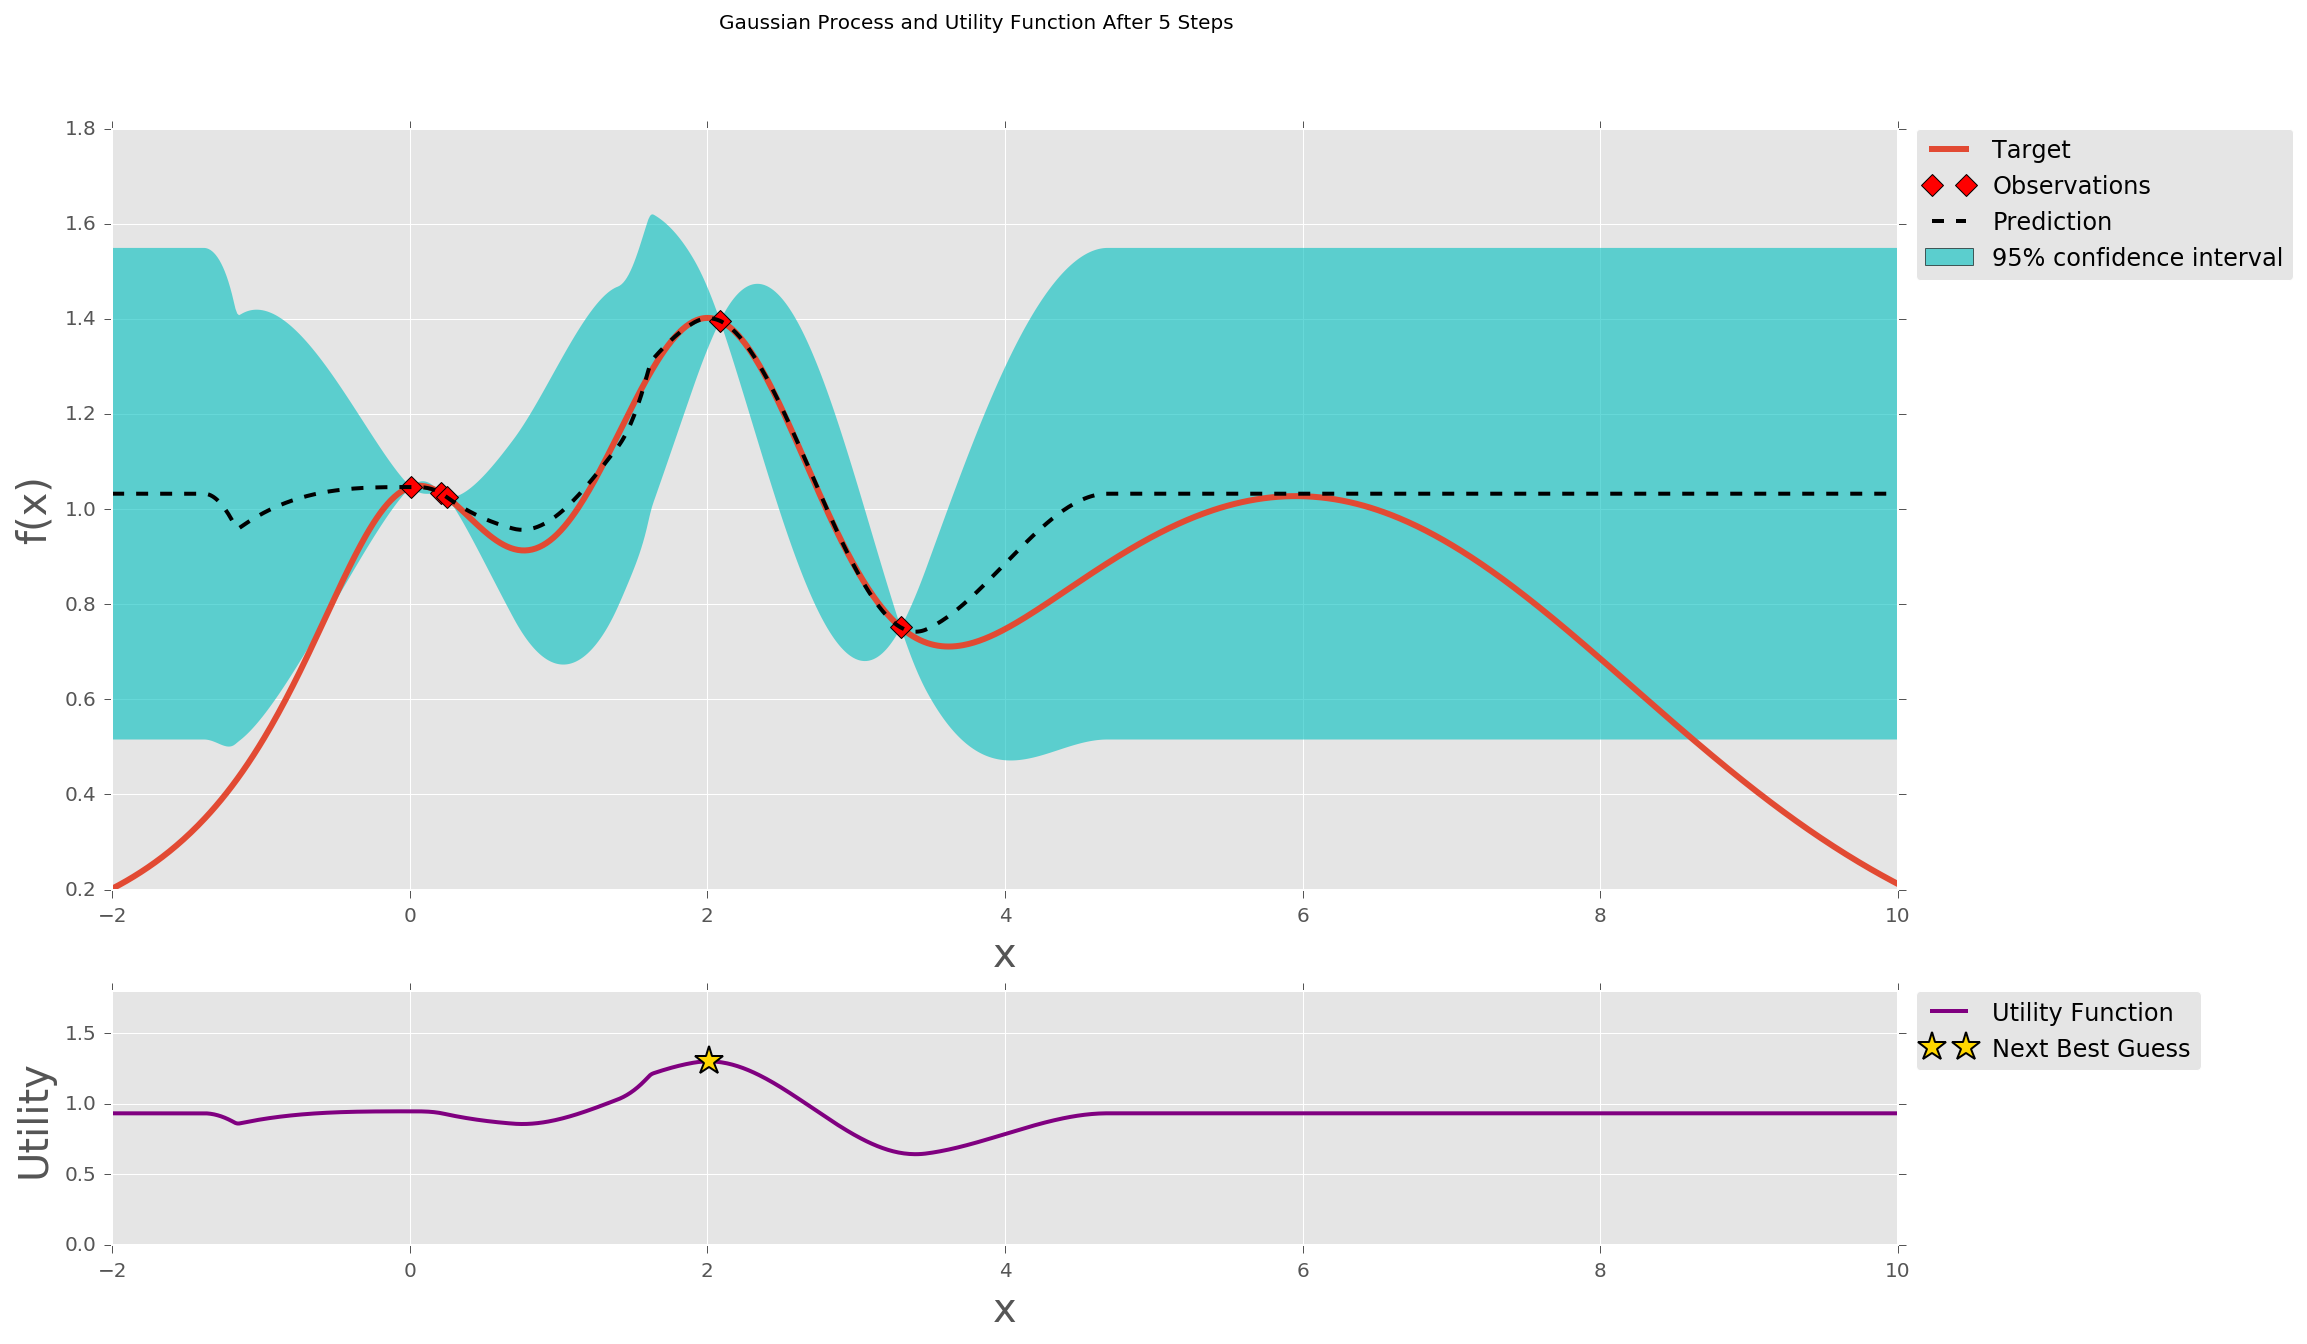

In [81]:
bo.maximize(init_points=5, n_iter=0, **max_params, **gp_params)
plot_gp(bo, x, y)

### After one step of GP (and two random points)

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
   13 | 00m01s |    1.18178 |    1.4410 | 


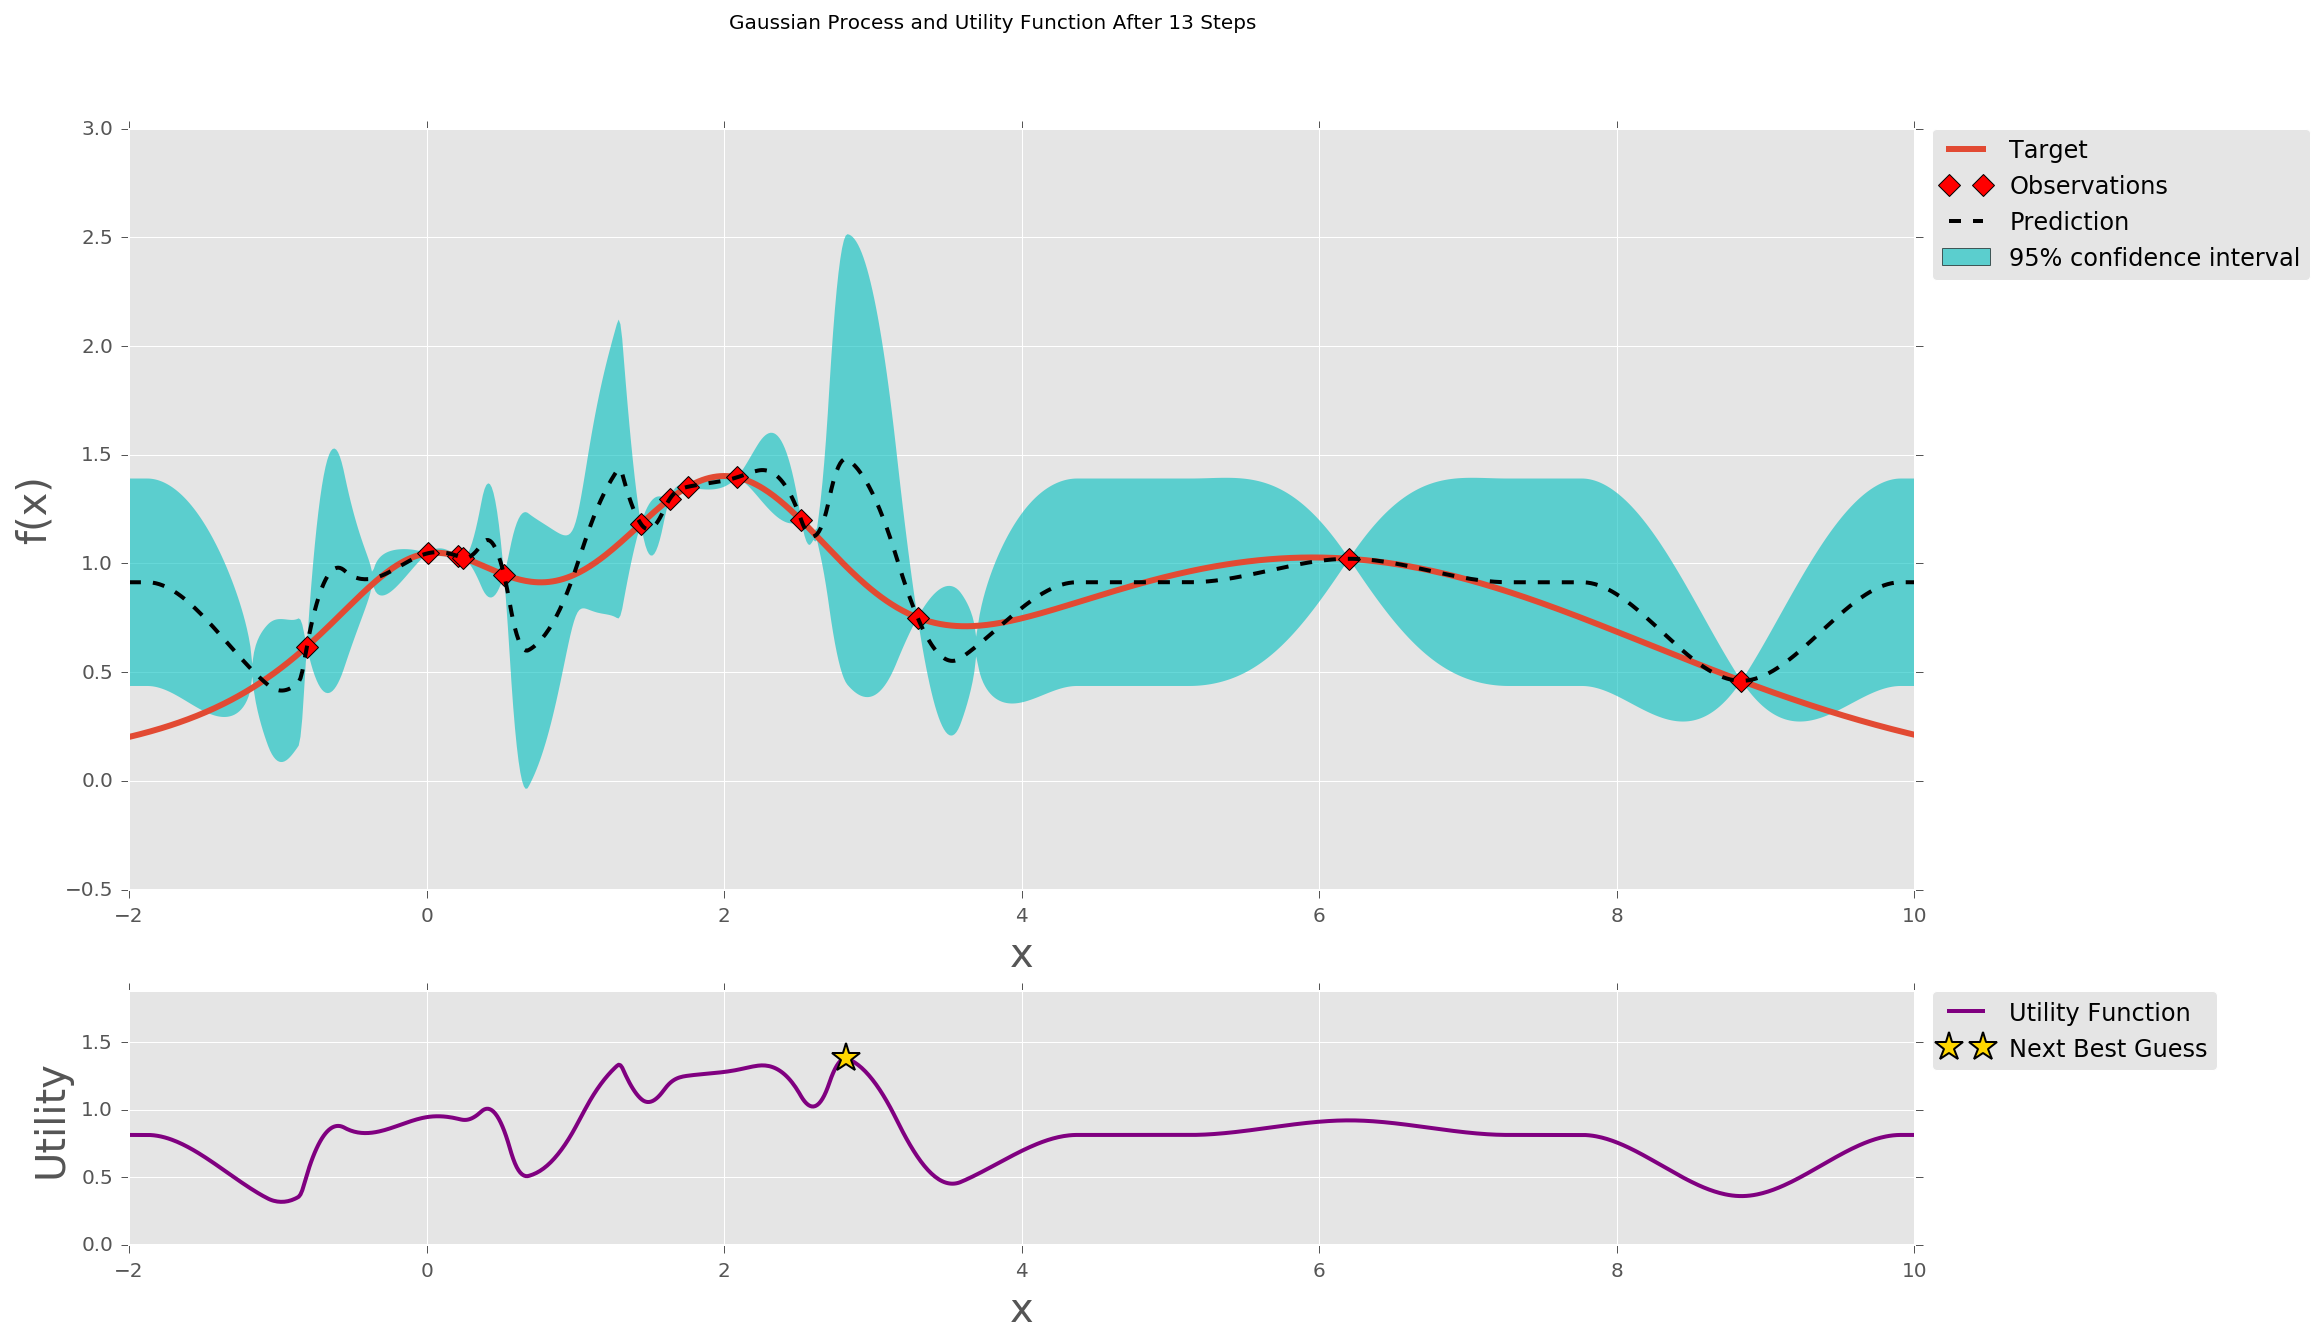

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
   14 | 00m02s |    0.98214 |    2.8257 | 


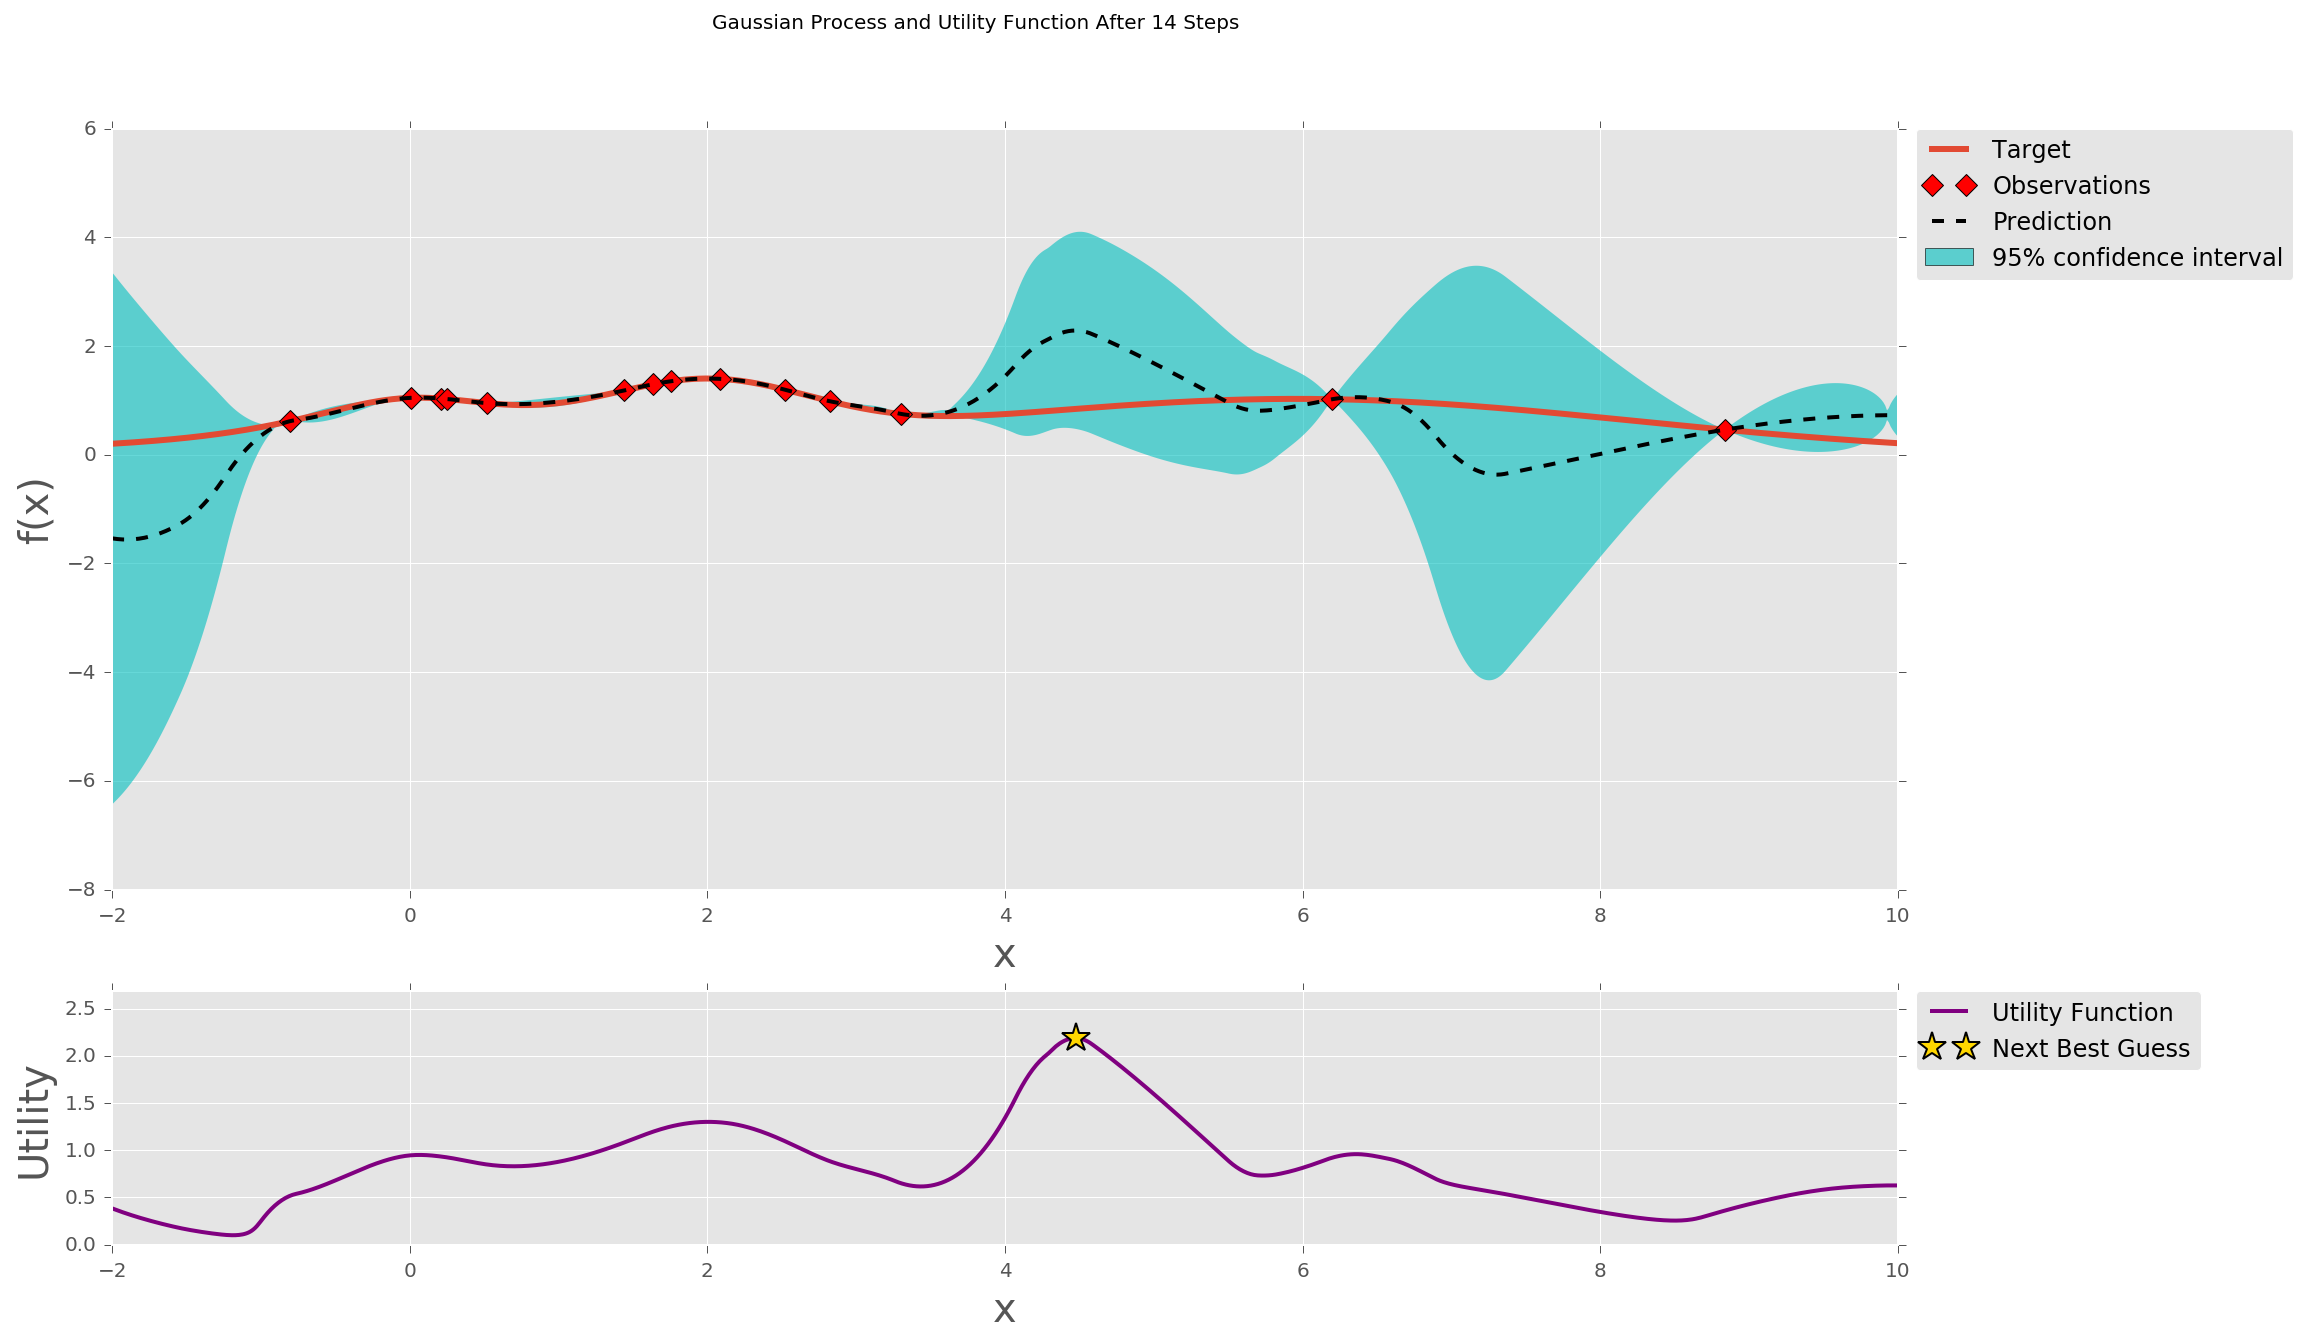

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
   15 | 00m01s |    0.84325 |    4.4797 | 


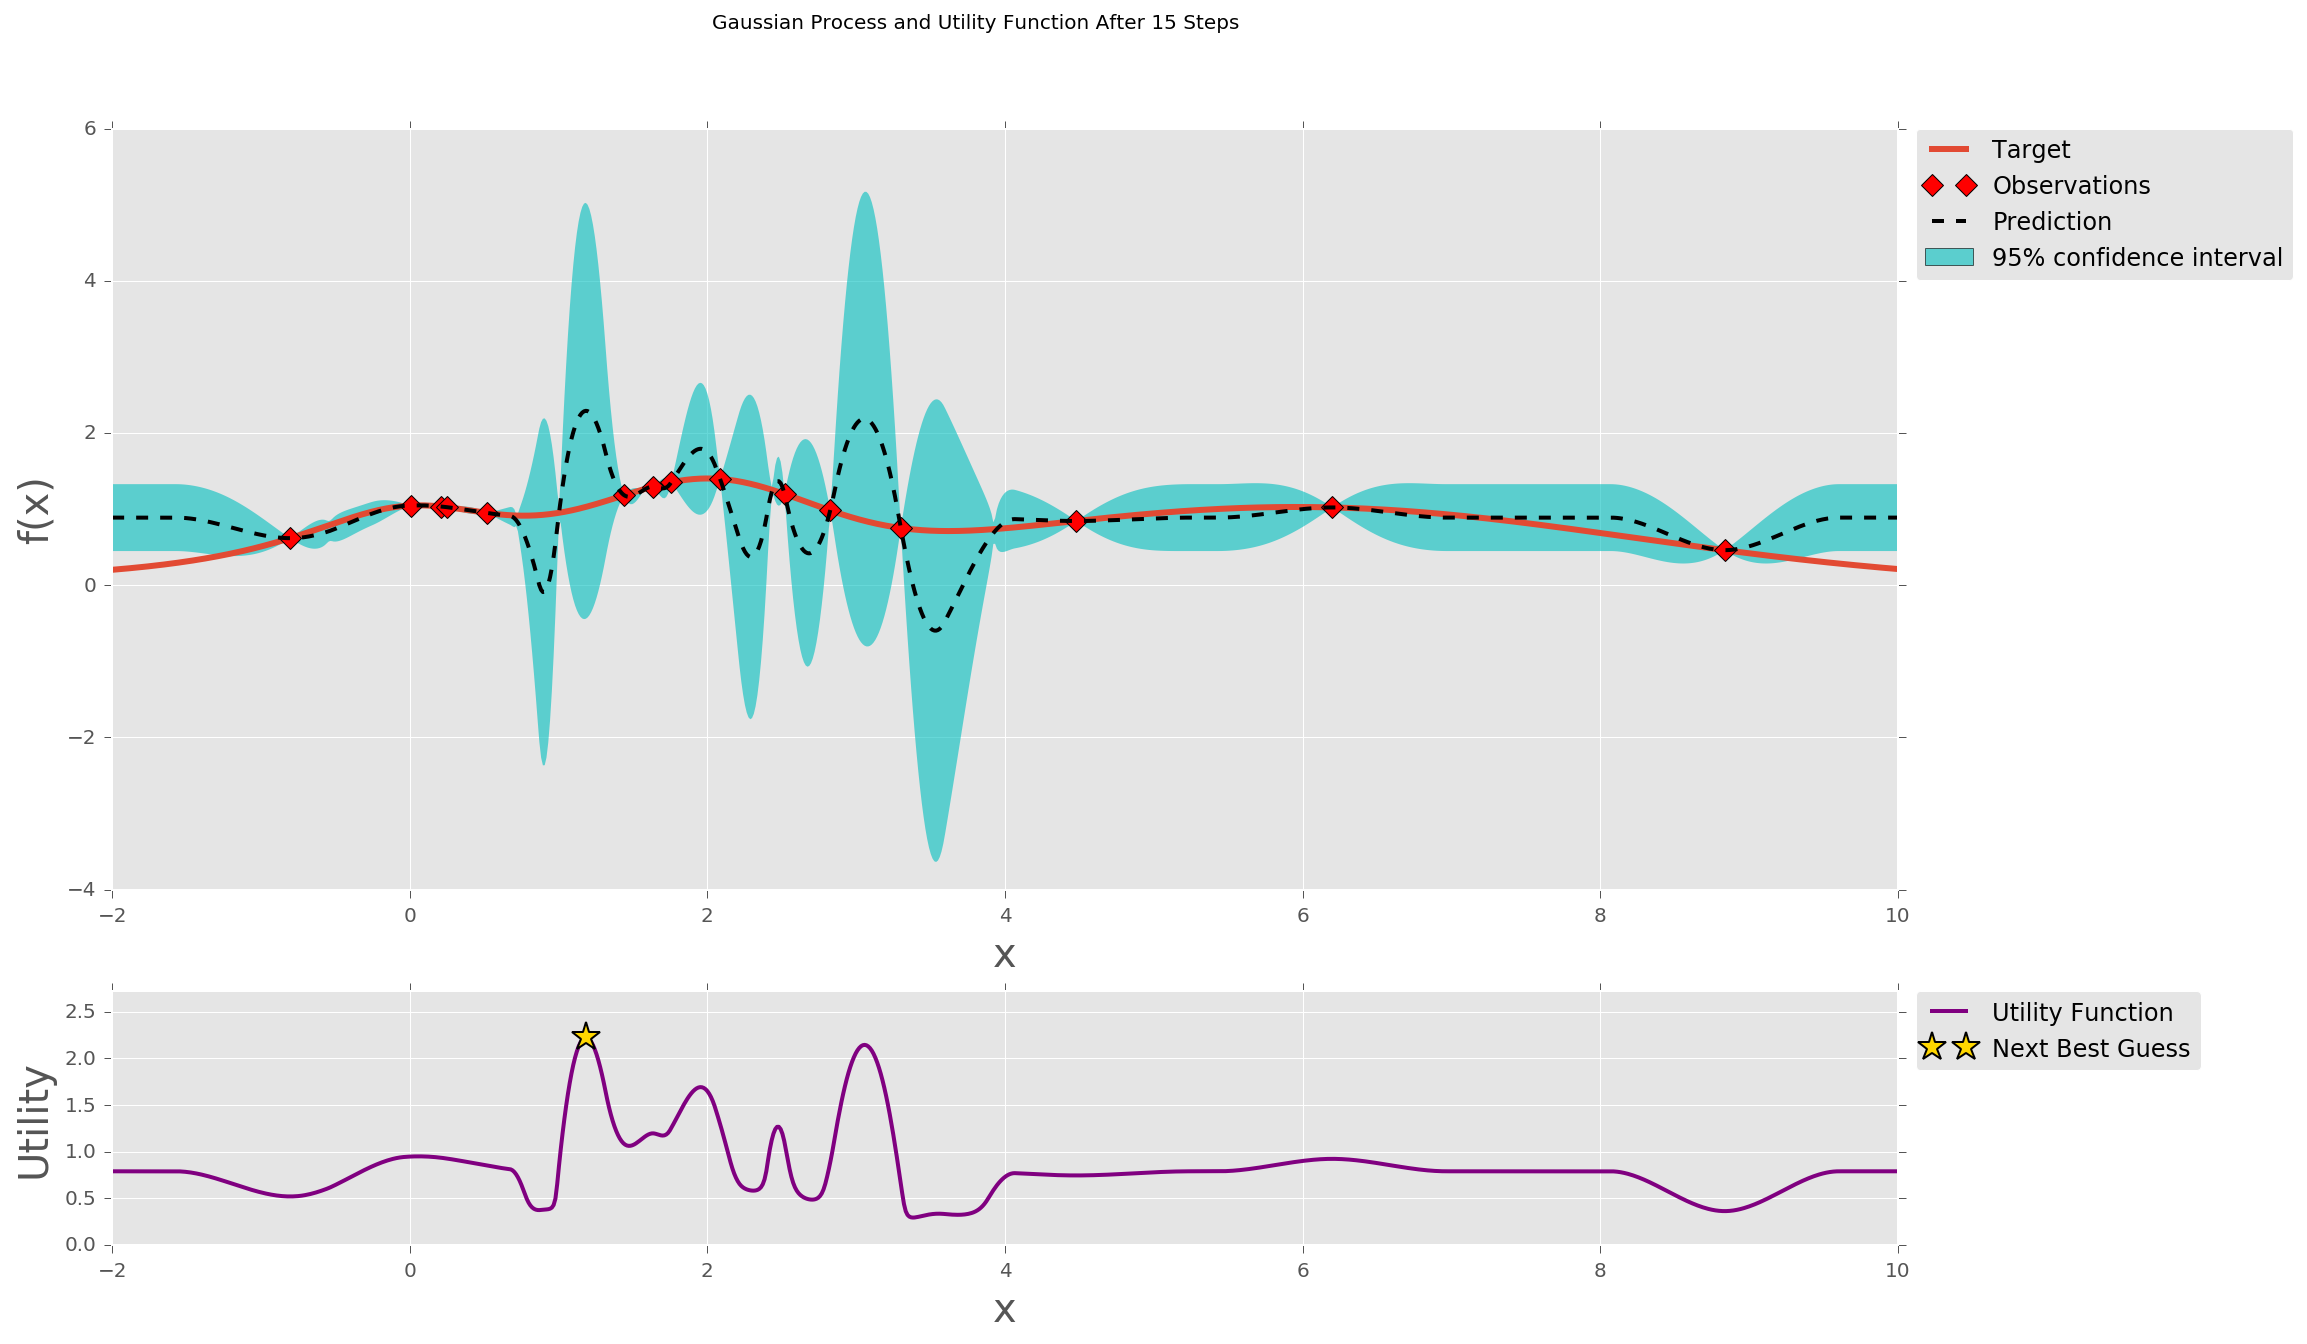

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
Optimization failed. Try increasing the ``nugget``


/Users/dsuess/Library/Miniconda3/lib/python3.5/site-packages/sklearn/gaussian_process/correlation_models.py:230: RuntimeWarning: invalid value encountered in greater
  td[td > 1.] = 1.


ValueError: array must not contain infs or NaNs

In [89]:
for _ in range(5):
    bo.maximize(init_points=0, n_iter=1, **max_params)
    plot_gp(bo, x, y)
    pl.show()

In [ ]:
x